These notes consider secure merging of arrays using Berry Schoenmakers [MPyC](https://github.com/lschoe/mpyc) library for secure multiparty computation in Python. 

This document is available as a pdf but can also be run interactively as a Jupyter Notebook by downloading the ipynb file. Compiling the notebook will result in a correct pdf. Additionally, it is compatible to be compiled using the TU/e corporate LaTeX style.

The section [Prerequisites](#Prerequisites) deals with some technical requirements of running the software. It is followed by [Problem](#Problem) which formalizes the problem that we consider in these notes. The two sections that follow, [Merging `seclist`s](#Merging-seclists) and [Secure merging of `list`s](#Secure-merging-of-lists) look at two different approaches for solving this merging issue securely. Finally, in [Experimental results](#Experimental-results) we run the implementations with various parameters and show their performance.

%LaTeX needed, ideally is a Raw nbconvert LaTeX cell, but th|at is not supported everywhere<br/>
\setcounter{section}{-1}

# Prerequisites
In this section we consider the prerequisites for running the code in these notes. This section is merely included at the beginning of this document to allow for a logical structure of the corresponding Notebook and Python script where these commands should run first. 

> Do you want to reproduce this report including your own output results? Run this command:

```bash
jupyter nbconvert --execute --to=pdf --allow-errors "Secure Merging.ipynb"
```

First, we ensure we have installed and imported all requirements. We can only install the packages when we are using ipython.

In [1]:
try:
    %pip install mpyc>=0.9 numpy>=1.24.2 gmpy2>=2.1.5
except NameError: print("Not running in ipython environment, so not installing packages")

from mpyc.runtime import mpc
import math
import random
import sys

Note: you may need to restart the kernel to use updated packages.


At some point, we will run part of this notebook as a script; if we do, we start the `mpc` environment

In [2]:
if len(sys.argv) > 1:
    mpc.run(mpc.start())

For quick referencing, we use `seclist` and `secint`. When running from this notebook, `secint` will be the type of 32-bit integers, but when we run this notebook as a script, we can specify the bitlength using the `-L` argument

In [3]:
secint = mpc.SecInt()
from mpyc.seclists import seclist

# Problem
The problem that we consider is the problem of securely merging two lists of secure integers $x$ and $y$ into one list $z$. $x$, $y$ and $z$ shall be sorted non-decreasingly and hence may contain duplicates.

The problem is applied to the field of multiparty computation where the following restrictions apply: without the protocol specifying, there should be no information about the lists known to any of the participants or an outsider. Throughout these notes, we will consider 'securely merging' to mean that no information about the content, other than the length of each of $x$, $y$ and $z$ becomes known. Clearly, it is unavoidable to share the length of the array as each of the parties must hold a part of the values in the list. 

## Abstraction
To allow us to write general code, we generalize the format of the code here. We also define some helping functions we will use later.

In [4]:
class listMergerInterface:
    _done = False
    compareCount = 0
    length = None
    
    def __init__(self, listA, listB):
        self.listR = listA + listB
        if self.length == None: self.length = len(listA) + len(listB)

    @mpc.coroutine
    async def _merge(self):
        raise NotImplementedError("Trying to run merge on an abstract interface")
    
    @mpc.coroutine
    async def _padd(self, α, N = 0):
        if N == 0: #By default we pad to the next power of 2
            N = 2**math.ceil(math.log(len(α),2))
        for i in range(len(α), N):
            α.append(secint(2**32 - 1))
    
    # Coroutine to swap elements u and v of an array t if c is True
    @mpc.coroutine
    async def _swap(self, t, u, v):
        t[u], t[v] = mpc.if_swap(
            c,
            t[v],
            t[u]
        )
    
    @mpc.coroutine
    async def merge(self):
        await mpc.returnType(secint, self.length)
        if self._done == False:
            self._merge()
            self._done = True
        # We know this already before doing it
        print("Total number of comparisons: " + str(self.compareCount))
        return self.listR

# Merging `seclist`s
In this algorithm, we implement the classic merge of two sorted arrays. We declare two indexes, i for list A, and j for list B. Then we iterate through the arrays, at each step, we compare the elements at the current indices. We add the smallest one to the result list R, and increase the respective index. One small detail is that we also append a `MAX_INT` value, $2^{32} - 1$ as the last element of the list, this way we never iterate through the whole array and we can keep making comparisons until the end, thus keeping the computation oblivious. At the end of the computation, we return the final list without including those 2 elements.

## Correctness
Since both lists are already ordered in ascending order, and we keep adding the smallest element between the two lists, from left to right, at each iteration, the final list R will also be sorted. The algorithm works for lists of different sizes.

## Security
In our implementation, the lists are secure lists, as well as the indices i and j. Keeping the indices secret makes it so the parties do not know if elements of array A or B are being added to R. Keeping them public would leak that an element of which array is being added to R at every step.  We also make use of secure if statements and comparisons at all times. The only information being leaked is the length of the arrays, but that is not a problem.

## Complexity and run-time
The algorithm runs in linear time of operations and comparisons, so $O(n)$, where $n$ is the length of the final array. The space complexity is also linear because the merging does not happen in-place. This algorithm is not very performant for multi-party computation because we need to use both secure lists and 2 secure integers. Seclists are also very slow, this solution uses the most of communication bytes between the algorithms algorithm presented in the assignment and it is the slowest by far.


In [5]:
class seclistMerge(listMergerInterface):
    @mpc.coroutine
    async def __init__(self, listA, listB):
        self.length = len(listA) + len(listB)
        # We add extra elements to prevent looping back to the first element
        # We never add these to the inal list because we stop once we have len(p) + len(q) elements
        listA.append(2**32 - 1)
        listB.append(2**32 - 1)
        self.listA = listA
        self.listB = listB
        super().__init__(listA, listB)
        self.listR = seclist([], secint)

    @mpc.coroutine
    async def _merge(self):
        p, q = self.listA, self.listB
        
        i,j = secint(0),secint(0) #Indices may reveal where we are
        r, n = self.listR, self.length

        while len(r) < n:
            # We use a secure if else statement so you don't know which number we are adding to the result list
            c = mpc.and_(
                    mpc.lt(p[i],q[j]),
                    mpc.lt(i, len(p) - 1) # To make sure we never add the last element of p
            ); self.compareCount += 1
            new_number = mpc.if_else(c, p[i], q[j])
            increase_i = mpc.if_else(c,1,0)
            r.append(new_number)

            # Our position j in the second list is always len(r) - i
            i += increase_i
            j = len(r) - i

# Secure merging of `list`s
This section considers solutions that do not user `MPyC`s `seclist` datatype, but instead rely on secure integers that are stored in normal arrays.

## Bitonic merge (and sort)
The second algorithm we consider is another by Batcher. His bitonic sorter\cite{wiki-batcherbitonic} is an algorithm that works on two arrays of equal length where that length is a power of two. We opt to generalize this by padding both arrays to a power of two they both fit in: $2^{\lceil {\log_2{\max(|listA|,|listB|}} \rceil}$. On output, we use the fact that we only return the `self.length` items we specified.

It is possible to generalize this algorithm to work on arrays of arbitrary length; however, to ensure obliviousness this requires the same amount of comparisons as by padding the array to the next power of 2.

### Correctness
The idea of the bitonic sorter is that it sorts a list by first sorting two sublists of size $\frac{n}{2}$, one ascending and one descending, to obtain a bitonic list of size $n$. This list is then again sorted by comparing the $i$th element to the $i + \frac{n}{2}$th element, the $i + \frac{n}{4}$th element, .., $i + \frac{n}{n}$th element, thus comparing each element to $\log_2{n}$ elements. In the implementation below, we do it slightly more involved by computing the bitwise or of the partner and making sure we only do forwards comparisons ($i>l$).

When we start the array is bitonic, which means that the element that is stored at position $0$ is smaller than at least $\frac{n}{2^1} - 1$ elements, because elements $1 ... \frac{n}{2^1}$ are guaranteed to be smaller. Hence, it never moves down more than $\frac{n}{2^1}$ positions. The same holds for all elements until position $\frac{n}{2^1}$. We will also never move an element up more than this amount. Thus, after we have run the algorithm for $j = 1$, we know that the lower half of the array is in the first half and the highest numbers are in the second half. After we have run for $j=2$, we have split it in $2^2=4$ parts. After we have run it for all $j$s, we are left with a sorted array. 

### Security
The algorithm works on lists of secure integers. This means that all parties can see what integers we are updating. However, as is the case for [Batcher's odd-even mergesort](Batcher's-odd-even-mergesort), the indices of the elements we update only depend on the length of the array which is public. This means that the indices can be public knowledge. 

The swaps we perform use the built-in conditional swap function `if_swap` which will perform a swap securely: $x, y = x + d, y - d$ with $d = c * (y-x)$ the difference depending on the condition $c$ which is 1 if we need to swap and 0 otherwise. Since we are always updating both elements, none of the parties know which elements we are swapping. 

Note that to ensure security, we cannot use the optimization that is argued for traditional algorithms. If $i$ and $i + \frac{n}{2^j}$ are swapped, you normally always need to swap $i + 1$ and $i + \frac{n}{2^j}$. However, we may not take this optimization because this condition is not secure and computing the OR securely will take the same amount of time as doing another comparison. Another frequently argued optmization is that once element $i$ is swapped into $i + \frac{n}{2^j}$, we will never have to update $i + \frac{n}{2^j}$ again, but we also cannot keep track of elements we have already updated. 

### Complexity and runtime
As argued before, we compare each of the $n$ elements to $\log_2{n}$ other elements. Taking into account $i>l$ means we do $\dfrac{n \cdot \log_2{n}}{2} = n \cdot (\log_2{n}-1)$ comparisons. This is both an upper and lower bound on the number of comparisons as we will see in the experimental part of these notes.

Depending on the result of the comparison, we perform a swap. Due to the nature of multiparty-computation, we will always perform this swap. However, the swap does not require an extra operation. This means that all our comparisons include a swap. The complexity of the swap is linear in the amount of parties; we add once and we subtract once, which is linear and we do one multiplication which is slightly worse. To verify this, we check that the amount of time we take is linear in the number of comparisons. 

### A note on sorting
Note that we only consider the bitonic merging part of the algorithm, i.e. one round; it is possible to extend this to multiple rounds to get a full sorting algorithm, by replacing the loop for $k$ and before swapping checking whether you are in an increasing part or decreasing part of the full list.

When 'upgrading' the bitonic merge to a bitonic sorter, complexity increases from $n \cdot (\log_2{n}-1)$ comparisons to $n \cdot (\log_2{n}-1) \cdot \log_2{n}$ comparisons as you have to do $\log_2{n}$ rounds to sort the sublists of length $1, 2, 4, \dots, n$.

In [6]:
class bitonicMerge(listMergerInterface):
    @mpc.coroutine
    async def __init__(self, listA, listB):
        self.length = len(listA) + len(listB)
        maxLength = 2**math.ceil(math.log(max(len(listA),len(listB)),2))
        self._padd(listA, N=maxLength)
        self._padd(listB, N=maxLength)
        listB.reverse()
        super().__init__(listA, listB)

    @mpc.coroutine
    async def _merge(self):
        r, N = self.listR, len(self.listR)

        # If the input is not bitonic, we may use the following instead
        #for k in [2**z for z in range(0,math.ceil(math.log(N+1,2)))]:
        for k in range(N,N+1):
            for j in [math.floor(k*2**(-z)) for z in range(1,math.ceil(math.log(k+1,2)))]:
                    for i in range(0,N):
                        l = i ^ j
                        if (l > i):
                            #Decide using bitwise and if we are in the ascending 
                            #or descending part, NOT relevant for merging
                            if (i & k == 0): #Ascending
                                c = mpc.lt(r[l], r[i]); self.compareCount += 1
                                r[i], r[l] = mpc.if_swap(c, r[i], r[l])
                            else: #Descending, only relevant with sublists
                                c = mpc.lt(r[i], r[l]); self.compareCount += 1
                                r[i], r[l] = mpc.if_swap(c, r[i], r[l])

## Batcher's odd-even mergesort

The first algorithm that we implement is a variant of Batcher's odd-even mergesort. The implementation given below is based on the pseudocode on the corresponding Wikipedia page\cite{wiki-batcheroddeven}. 

Note that due to the way the merging network is constructed, we must always execute the full depth and cannot optimize based on the knowledge we already have about the existing sorting; this also means it is possible to merge arrays of non-equal length. This algorithm is able to sort arrays of arbitrary length, including numbers that are not a power of 2. 

### Security
The algorithm performs the same steps for every input of the same size, regardless of the values, so all the indices can be kept public. The only secret operation is the if statement where we can secretly swap the two elements.

### Correctness
The algorithm is built upon the iterative use of the merging networks as shown in \cite{batchersort}. A detailed proof of Batcher's odd-even merge can be found in Appendix A of aforementioned paper.

### Complexity and run-time
For this algorithm, we double a $p$ continuously until we hit $N$. This means we take $\log_2{N}$ steps. For each of these $p$s we take $\log_2{p}$ different $k$s for which we range over all elements of $N$. For all of these, we do a single comparison and exactly one swap. This means we take $\Theta(N \cdot \log^2_2{n})$ comparisons. We have argued that time is linear in the amount of comparisons, so that is also our time complexity. 

In [7]:
class batcherMerge(listMergerInterface):
    @mpc.coroutine
    async def _merge(self):
        r, N = self.listR, len(self.listR)

        for p in [2**i for i in range(0,math.floor(math.log(N,2)) + 1)]:
            for k in [round(p * 2**(-i)) for i in range(0,math.floor(math.log(p,2)) + 1)]:
                for j in range(k % p, N-k, 2*k):
                    for i in range(0, min(k,N-j-k)):
                        if ((i + j) // (p*2) == (i+j+k)//(p*2)):
                            c=mpc.lt(r[i+j+k],r[i+j]); self.compareCount += 1
                            r[i+j+k], r[i+j] = mpc.if_swap(c, r[i+j+k], r[i+j])

## Knuth's merge-exchange sort
This algorithm is an implementation of the merge-exchange sorting algorithm Knuth \cite{knuth} attributes to Batcher. We implemented algorithm M from \cite{knuth}. This is an optimization of our implementation of Batcher's algorithm for merging. Due to the way this algorithm is constructed, we are also able to only merge arrays with length a power of 2. 

## Correctness
Due to the highly optimized nature, the proof is quite elaborate, but various variants can be found in \cite{knuth} pages 111-114. The code below is annotated with the corresponding steps \texttt{M1} to \texttt{M6} in \cite{knuth}.

## Security
As was the case for the [Bitonic sort](#Bitonic-sort), the steps of the algorithm only depend on the value of $N$, being the length of the array. This means that we don't leek any information that was not public before by performing the steps. Whether we swap two elements or not depends on a condition we securely evaluate, always updating both elements using aforementioned `if_swap`. 

## Complexity and run-time
When we look at the algorithm, we see the outer loop starts at $p = 2^t \approx N$ where $N$ is the length of the array. We half this each time, so we do $\log_2{n}$ steps in this outer loop. Then we linearly range over somewhere between $\frac{N}{2}$ and $N$ elements. This will take approximately the same amount of steps as the previously mentioned bitonic merge, skipping a few items potentially, but ending at $\Theta(N \cdot \log_2{N})$ comparisons.

In [8]:
class knuthMerge(listMergerInterface):
    @mpc.coroutine
    async def __init__(self, listA, listB):
        self.length = len(listA) + len(listB)
        maxLength = 2**math.ceil(math.log(max(len(listA),len(listB)),2))
        self._padd(listA, N=maxLength)
        self._padd(listB, N=maxLength)
        super().__init__(listA, listB)
        
    @mpc.coroutine
    async def _merge(self):
        R, N =  self.listR, len(self.listR)

        t = math.ceil(math.log(N,2)) #M1
        p = 2**(t-1)
        while p > 0: #M1
            #print("p=" + str(p))
            q = 2**(t-1)            #M2
            r = 0                   #M2
            d = p                   #M2
            for i in range(0, N-d): #M3
                if i & p == r:      #M3
                    c = mpc.lt(R[i], R[i+d]); self.compareCount += 1
                    R[i], R[i+d] = mpc.if_swap(c, R[i+d], R[i]) #M4
                while q != p: #M5
                    d = q - p #M5
                    q = q//2  #M5
                    r = p     #M5
            p //= 2 #M6

# Experimental results
To confirm a few of the aforementioned bounds, we collected data on the various algorithms. [Appendix A](#Data-collection) describes how the framework was set up to collect the data. There is a few different results we gathered, each explained in their own section.

## Relation between number of comparisons and time
Some of the proofs argued that time complexity was linear in the number of comparisons. In [Figure 3](#Figure-3), we show that this is indeed the case for [Batcher's odd-even mergesort](#Batcher's-odd-even-mergesort), [Knuth's merge-exchangesort](#Knuth's-merge-exchange-sort) and [Bitonic merge](#Bitonic-merge-(and-sort)). 

## Relation between array length and time
For each of the algorithms, we run the algorithm with 3 parties and various array length. They have been plotted in [Figure 1](#Figure-1). A detail for array lengths up to 128 is shown in [Figure 2](#Figure-2). 

For the implementation using `seclist`, we see that the amount of time increases by a lot when we double the array size. For $|x| = |y| = 128$ we see that it takes almost a minute to run. For $|x| = |y| = 256$, we see that we already need more than double the amount of time. This means that this implementation is not very scalable to larger input sizes which corresponds to the time complexity argued before.

We see that Batcher's odd-even mergesort is slightly quicker than that, but still takes a lot of time.

Although Knuth's exchange mergesort and Bitonic merge don't look alike, their performance is always best in our testcases, merging two arrays of 1024 elements in less than 1 minute.

## Relation between number of parties and time
We also looked at the number of parties with which we run the algorithm. For a fixed length $|x| = |y| = 16$, we run all of the algorithms and get the result as shown in [Figure 4](#Figure-4). 

Apart from noticing that the `seclist` implementation again is the slowest, we can also see that it increases in time quite a bit as does Batcher's odd-even mergesort. For Knuth's exchange-mergesort and Bitonic merge by Batcher, we see that we get much more realistic results for larger number of parties so those algorithms are clearly recommended when running with larger arrays and more parties. 


% nbconvert does not allow us to use BibTeX easily, so we will do it this way
\begin{thebibliography}{1}
\bibitem{batchersort} Sorting networks and their applications (1968) \emph{Batcher, K. E.}. Spring Joint Computer Conference. Available at: \url{https://www.cs.kent.edu/~batcher/sort.pdf} (Accessed: April 12, 2023).
\bibitem{knuth} The art of computer programming: Volume 3: Sorting and Searching (1998) \emph{Knuth, D. E.}. Addison-Wesley Professional.
\bibitem{wiki-batcheroddeven} Batcher odd–even mergesort (2023) \emph{Wikipedia}. Wikimedia Foundation. Available at: \url{https://en.wikipedia.org/w/index.php?title=Batcher_odd-even_mergesort\&oldid=1149453264} (Accessed: April 12, 2023).
\bibitem{wiki-batcherbitonic} Bitonic sorter (2023) \emph{Wikipedia}. Wikimedia Foundation. Available at: \url{https://en.wikipedia.org/w/index.php?title=Bitonic_sorter&oldid=1140526862} (Accessed: April 12, 2023).
\end{thebibliography}

\newpage
\appendix

# Data collection
This appendix explains the experimental results that were obtained and referenced to


In [9]:
@mpc.coroutine
async def randomSortedList(length,seed):
    # To be able to pre-sort the two lists, we need regular integers here
    # and cannot work with secure integers, because then we would need to 
    # sort regular lists of secure integers which we can't
    # We actually need to set the seed immediately before we generate the 
    # list for consistency reasons
    random.seed(seed)
    l = list()
    for i in range(0,length):
        l.append(random.randint(0,2**20))
    l.sort()
    return l

async def main(algorithm, subarraylength):
    global listCombined
    
    # We share a random value to generate the same list on both endpoints
    rnd = await mpc.output(mpc.random.randint(secint, 0, 2**31))
    listA = randomSortedList(subarraylength,rnd)
    listB = randomSortedList(subarraylength,rnd+1)

    # The result we want to obtain
    listCombined = listA + listB
    listCombined.sort()
    
    listA = [secint(a) for a in listA]
    listB = [secint(a) for a in listB]
    
    match algorithm:
        case 'seclist':
            # Convert the input to secure lists
            listA = seclist(listA, secint)
            listB = seclist(listB, secint)
            sortObj = seclistMerge(listA, listB)
        case 'batcher':
            sortObj = batcherMerge(listA,listB)
        case 'knuth':
            sortObj = knuthMerge(listA,listB)
        case 'bitonic':
            sortObj = bitonicMerge(listA,listB)
        case _:
            print("specify one of seclist, batcher, knuth or bitonic")
            sys.exit()
    
    output = await mpc.output(sortObj.merge())
    #rint(output)

    print("List sorted?: " + str(output == listCombined))
    #rint(listCombined)
    
    return

if len(sys.argv) > 1:
    mpc.run(main(sys.argv[1], int(sys.argv[2])))

In [10]:
if len(sys.argv) > 1:
    mpc.run(mpc.shutdown())
    import sys; sys.exit()
    quit

We convert the current script to a Python file (which stops at above `sys.exit()`) so we can call this script later. 

In [11]:
!jupyter nbconvert --to=python --allow-errors "Secure Merging.ipynb" --output="Secure_Merging.py"

[NbConvertApp] Converting notebook Secure Merging.ipynb to python
[NbConvertApp] Writing 30604 bytes to Secure_Merging.py


In [12]:
import os
def runOne(participants, algorithm, arraysize, bitlength=32):
    result = {"Algorithm": algorithm, "Array size": arraysize}
    command = "python Secure_Merging.py -M%d -B 11443 -L%d '%s' %d" % (participants, bitlength, algorithm, arraysize)
    #command = "ipython Secure_Merging.py -- -M%d -B 11443 -L%d '%s' %d" % (participants, bitlength, algorithm, arraysize)
    cmd_output = os.popen(command).read()
    for line in cmd_output.split("\n"):
        if "List sorted?" in line:
            result["Sorted"] = line == "List sorted?: True"
            if not result["Sorted"]: raise RuntimeError("Output is not correct")
        if "Total number of comparisons" in line:
            result["Comparisons"] = int(line[29:])
        if "parties connected" in line:
            result["Parties"] = int(line.split("All ")[1].split(" ")[0])
        if "elapsed time" in line:
            result["Time"] = line.split("elapsed time: ")[1].split("|")[0]
            result["Bytes"] = int(line.split("bytes sent: ")[1])
    if len(result) < 6: raise RuntimeError(cmd_output.split("\n"))
    return result

In [13]:
algorithms = {
    "seclist": "#ff7f00",  #orange
    "batcher": "#984ea3",  #purple
    "knuth":   "#377eb8",  #blue
    "bitonic": "#999999",  #gray
}

In [14]:
runOne(3, "seclist", 10)

{'Algorithm': 'seclist',
 'Array size': 10,
 'Parties': 3,
 'Comparisons': 20,
 'Sorted': True,
 'Time': '0:00:02.103',
 'Bytes': 281502}

In [15]:
%pip install pandas
%pip install matplotlib
import pandas as pd
from IPython.display import display

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [16]:
df = pd.DataFrame(columns=["Algorithm", "Array size", "Parties", "Sorted", "Comparisons", "Time", "Bytes"])

In [17]:
# Here we generate data for the various algorithms:
for length in [2**i for i in range(0, 11)]:
    for algorithm in algorithms.keys():
        if length >= 257 and algorithm == "seclist": continue
        if length >= 513 and algorithm == "batcher": continue
        display("Doing " + str(algorithm) + " for length " + str(length),clear=True)
        df.loc[len(df)] = runOne(3, algorithm, length)
        
for length in [2**i - 2**(i-2) for i in range(3,8)]:
    for algorithm in algorithms.keys():
        if length >= 257 and algorithm == "seclist": continue
        if length >= 513 and algorithm == "batcher": continue
        display("Doing " + str(algorithm) + " for length " + str(length),clear=True)
        df.loc[len(df)] = runOne(3, algorithm, length)

'Doing bitonic for length 96'

In [18]:
df

,Algorithm,Array size,Parties,Sorted,Comparisons,Time,Bytes
0,seclist,1,3,True,2,0:00:00.220,26894
1,batcher,1,3,True,1,0:00:00.066,4264
2,knuth,1,3,True,1,0:00:00.047,4012
3,bitonic,1,3,True,1,0:00:00.151,4516
4,seclist,2,3,True,4,0:00:00.421,53000
...,...,...,...,...,...,...,...
56,bitonic,48,3,True,448,0:00:01.873,619194
57,seclist,96,3,True,192,0:00:35.949,4102206
58,batcher,96,3,True,2784,0:00:13.254,3829374
59,knuth,96,3,True,904,0:00:03.501,1246922


In [19]:
# A few basic data conversions
df["Color"] = df["Algorithm"].map(lambda x:algorithms[x])
df['TimeAlt'] = pd.to_datetime(df['Time'], format="%H:%M:%S.%f",errors='coerce')

## Figure 1

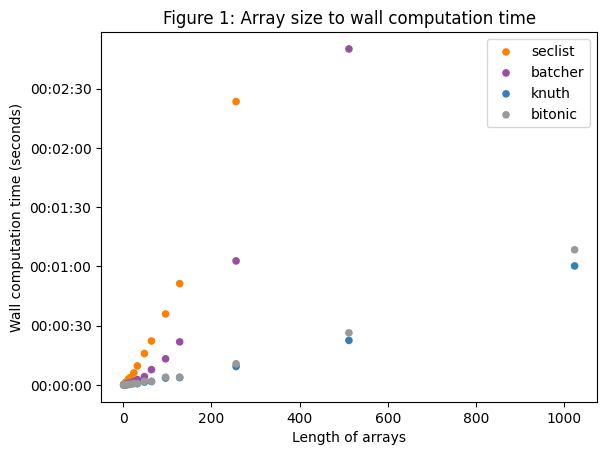

In [20]:
#ax = df.plot(kind='scatter', x="Array size", y="TimeAlt", c="Color", legend=True, label="Algorithm")
ax = None
for algorithm in algorithms.keys():
    ax = df[df["Algorithm"] == algorithm].plot(kind='scatter', x="Array size", y="TimeAlt", c="Color", legend=True, label=algorithm, ax=ax)
ax.set_title("Figure 1: Array size to wall computation time")
ax.set_xlabel("Length of arrays")
ax.set_ylabel("Wall computation time (seconds)")
ax.get_figure().savefig("fig_scatter_size_time.pdf")


## Figure 2

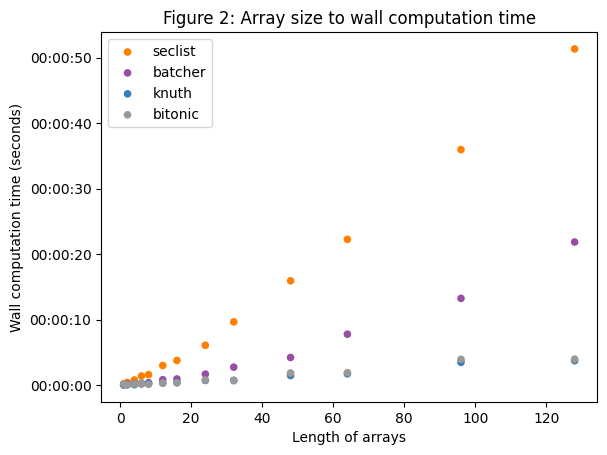

In [21]:
#ax = df.plot(kind='scatter', x="Array size", y="TimeAlt", c="Color", legend=True, label="Algorithm")
ax = None
for algorithm in algorithms.keys():
    ax = df[((df["Algorithm"] == algorithm) & (df["Array size"] <= 128))].plot(kind='scatter', x="Array size", y="TimeAlt", c="Color", legend=True, label=algorithm, ax=ax)
ax.set_title("Figure 2: Array size to wall computation time")
ax.set_xlabel("Length of arrays")
ax.set_ylabel("Wall computation time (seconds)")
ax.get_figure().savefig("fig_scatter_size_time_detail.pdf")


## Figure 3

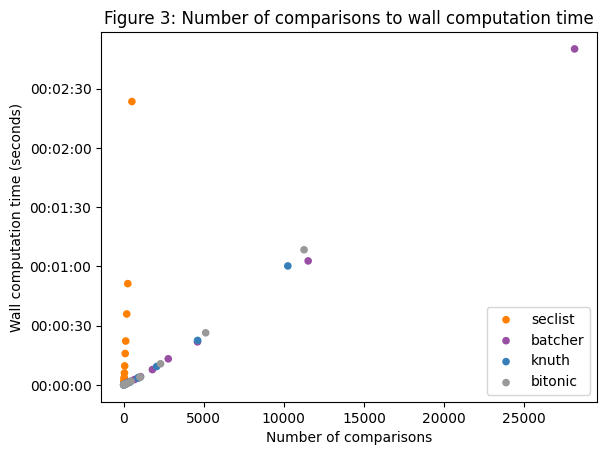

In [22]:
ax = None
for algorithm in algorithms.keys():
    ax = df[df["Algorithm"] == algorithm].plot(kind='scatter', x="Comparisons", y="TimeAlt", c="Color", legend=True, label=algorithm, ax=ax)
ax.set_title("Figure 3: Number of comparisons to wall computation time")
ax.set_xlabel("Number of comparisons")
ax.set_ylabel("Wall computation time (seconds)")
ax.get_figure().savefig("fig_scatter_comp_time.pdf")

## Figure 4

In [23]:
df_parties = pd.DataFrame(columns=["Algorithm", "Array size", "Parties", "Sorted", "Comparisons", "Time", "Bytes"])
# Here we generate data for the various algorithms:
for parties in range(2,12):
    for algorithm in algorithms.keys():
        display("Doing " + str(algorithm) + " for number of parties " + str(parties),clear=True)
        df_parties.loc[len(df_parties)] = runOne(parties, algorithm, 16)
# Basic data processing
df_parties["Color"] = df_parties["Algorithm"].map(lambda x:algorithms[x])
df_parties['TimeAlt'] = pd.to_datetime(df_parties['Time'], format="%H:%M:%S.%f",errors='coerce')

'Doing bitonic for number of parties 11'

In [24]:
df_parties

,Algorithm,Array size,Parties,Sorted,Comparisons,Time,Bytes,Color,TimeAlt
0,seclist,16,2,True,32,0:00:02.408,0,#ff7f00,1900-01-01 00:00:02.408
1,batcher,16,2,True,240,0:00:00.412,0,#984ea3,1900-01-01 00:00:00.412
2,knuth,16,2,True,69,0:00:00.173,0,#377eb8,1900-01-01 00:00:00.173
3,bitonic,16,2,True,80,0:00:00.186,0,#999999,1900-01-01 00:00:00.186
4,seclist,16,3,True,32,0:00:03.853,486376,#ff7f00,1900-01-01 00:00:03.853
5,batcher,16,3,True,240,0:00:00.968,333142,#984ea3,1900-01-01 00:00:00.968
6,knuth,16,3,True,69,0:00:00.290,97936,#377eb8,1900-01-01 00:00:00.290
7,bitonic,16,3,True,80,0:00:00.354,112968,#999999,1900-01-01 00:00:00.354
8,seclist,16,4,True,32,0:00:04.945,681448,#ff7f00,1900-01-01 00:00:04.945
9,batcher,16,4,True,240,0:00:01.336,423062,#984ea3,1900-01-01 00:00:01.336


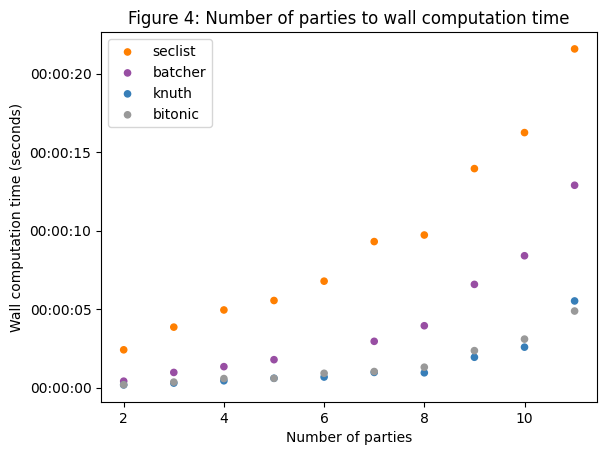

In [25]:
ax = None
for algorithm in algorithms.keys():
    ax = df_parties[df_parties["Algorithm"] == algorithm].plot(kind='scatter', x="Parties", y="TimeAlt", c="Color", legend=True, label=algorithm, ax=ax)
ax.set_title("Figure 4: Number of parties to wall computation time")
ax.set_xlabel("Number of parties")
ax.set_ylabel("Wall computation time (seconds)")
ax.get_figure().savefig("fig_scatter_parties_time.pdf")

# Running this notebook
To run this notebook, you must have also saved a copy of the script as a Python file. This can be done from the Jupyter Notebook interface or using the `nbconvert` terminal commands.

In the `File` menu, please select `Save and export notebook as...` and then `Executable Code` (or `Python` if using the classic interface)


## Exporting the pdf
This can again be done using `nbconvert` to output a `.tex` or directly from Jupyter to obtain a PDF. 

Using the TU/e template can be done by inserting the following code immediately before `\begin{document}`
```tex
\input{General/Preamble} % Loads in the preamble 
\input{General/Settings} % Loads in user defined settings
```
and replacing `\maketitle` with 
```tex
\input{Chapters/0. Frontpage}
\newpage
```